In [49]:
import networkx as nx
import numpy as np
import tsplib95
import random
import matplotlib.pyplot as plt
import time
from utils import get_distance_matrix as compute_euclidean_distance_matrix

In [50]:
filename="TSP_Instances/bier127.tsp"

Objective: 120494
Route:
 0 -> 15 -> 36 -> 35 -> 34 -> 43 -> 102 -> 44 -> 53 -> 56 -> 120 -> 4 -> 55 -> 123 -> 51 -> 99 -> 63 -> 57 -> 2 -> 89 -> 115 -> 59 -> 60 -> 90 -> 61 -> 58 -> 66 -> 72 -> 73 -> 67 -> 70 -> 69 -> 68 -> 74 -> 75 -> 77 -> 116 -> 83 -> 80 -> 125 -> 81 -> 82 -> 100 -> 101 -> 62 -> 118 -> 95 -> 108 -> 87 -> 86 -> 85 -> 84 -> 109 -> 103 -> 124 -> 88 -> 91 -> 98 -> 64 -> 112 -> 65 -> 54 -> 46 -> 52 -> 48 -> 117 -> 47 -> 45 -> 93 -> 111 -> 110 -> 106 -> 92 -> 94 -> 122 -> 96 -> 97 -> 31 -> 28 -> 24 -> 32 -> 121 -> 27 -> 41 -> 39 -> 40 -> 13 -> 11 -> 30 -> 26 -> 29 -> 42 -> 33 -> 38 -> 37 -> 25 -> 79 -> 78 -> 76 -> 17 -> 20 -> 16 -> 19 -> 107 -> 14 -> 105 -> 5 -> 23 -> 22 -> 3 -> 21 -> 18 -> 71 -> 7 -> 8 -> 10 -> 113 -> 104 -> 6 -> 119 -> 9 -> 114 -> 12 -> 49 -> 50 -> 1 -> 0
Distance: 120494m



TypeError: list indices must be integers or slices, not tuple

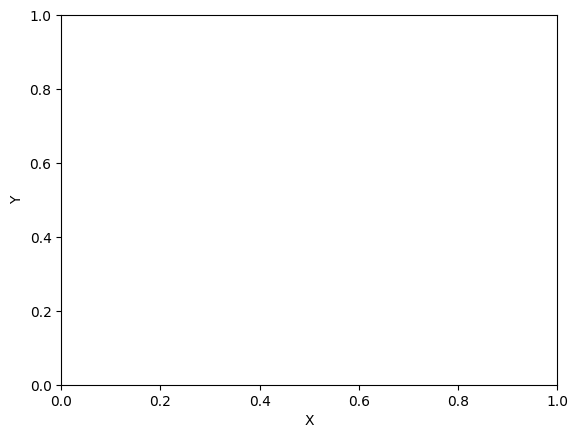

In [51]:
"""Simple Travelling Salesperson Problem (TSP) on a circuit board."""

import math
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp



def create_data_model(filename):
    problem = tsplib95.load(filename)
    tabCoords=[]
    for i in range(1,len(problem.node_coords)):
        tabCoords+=[problem.node_coords[i]]

    # Convertir la liste1 en un tableau NumPy
    tableau = np.array(tabCoords)

    # Obtenir les coordonnées x et y à partir du tableau
    x_coords = tableau[:, 0]
    y_coords = tableau[:, 1]

    # Créer une liste de tuples à partir des coordonnées x et y
    liste = [(x, y) for x, y in zip(x_coords, y_coords)]
    """Stores the data for the problem."""
    data = {}
    # Locations in block units
    data["locations"] = liste
    data["num_vehicles"] = 1
    data["depot"] = 0
    return data

def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    index = routing.Start(0)
    plan_output = "Route:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += f" {manager.IndexToNode(index)} ->"
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += f" {manager.IndexToNode(index)}\n"
    plan_output += f"Distance: {route_distance}m\n"
    print(plan_output)


def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model(filename)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["locations"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    distance_matrix = compute_euclidean_distance_matrix(data["locations"])

    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(manager, routing, solution)
    
    problem = tsplib95.load(filename)
    coords=[]
    for i in range(1,len(problem.node_coords)):
        coords+=[problem.node_coords[i]]

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    ax.scatter(coords[:,0], coords[:,1], c='r', marker='o')
    plt.title("Villes à rejoindre")
    plt.show()

    #Dessin du résultat   || EN COURS ||
    index = routing.Start(0)
    while not routing.IsEnd(index):
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
        ax.plot(coords[[previous_index],0],coords[[index],0],
                coords[[previous_index],1],coords[[index],1],
                c='b', linestyle='-')
    plt.show()

if __name__ == "__main__":
    main()